<center><b><font size=6>Language Models exploration<b><center>

This notebook focuses on experimenting with language models to solve the same supervised task as discussed in Section 2. The primary objective is to leverage the capabilities of advanced language models such as **BERT** or **Doc2Vec** for supervised learning tasks—specifically, assigning intents to sessions. 

### Key Concepts:
1. **Transfer Learning**:
   - Use a model pre-trained on vast datasets by tech companies.
   - Fine-tune this model on a smaller, domain-specific dataset for improved performance.

2. **Vector Encoding in NLP**:
   - Words or documents are transformed into vectors (encoding) through an **unsupervised process**.
   - This approach allows the use of significantly larger datasets during the training phase.

### Experiment Steps:
1. **Model Selection**:
   - Choose between **BERT** and **Doc2Vec**:
     - **Doc2Vec**: Pretrain on the session text's `body` column.
     - **BERT**: Use a pre-trained model, such as `BertForSequenceClassification` or another implementation from HuggingFace.

2. **Add a Dense Layer**:
   - Extend the model with a custom dense (fully connected) layer for the classification task.

3. **Fine-Tuning**:
   - Fine-tune the last layer of the network on the supervised training dataset for a fixed number of epochs.

4. **Plot Learning Curves**:
   - Visualize the training and validation loss curves.
   - Identify the optimal stopping point for training (early stopping based on validation performance).

<center><b><font size=5>Install Dependencies<b><center>

In [5]:
!python ../scripts/install_dependencies.py section4

Installing common packages: pandas, pyarrow
Installing Section 4 packages: matplotlib, scikit-learn, torch, transformers


In [1]:
import os
import time
import numpy as np
import pickle
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from transformers import BertTokenizer, BertModel, AdamW, get_scheduler
from tqdm import tqdm

<center><b><font size=5>Training<b><center>

In [2]:
# Paths for saving preprocessed data
TOKENIZED_TRAIN_PATH = "../data/processed/train_encodings.pkl"
TOKENIZED_VAL_PATH = "../data/processed/val_encodings.pkl"

In [3]:
# Load Dataset
print("Loading the dataset...")
df = pd.read_parquet("../data/processed/ssh_attacks_decoded.parquet")
print(f"Dataset loaded successfully with {df.shape[0]} rows.")

Loading the dataset...
Dataset loaded successfully with 233035 rows.


In [4]:
# Preprocess the 'Set_Fingerprint' column for multi-label encoding
print("Preprocessing 'Set_Fingerprint' column...")
df['Set_Fingerprint'] = df['Set_Fingerprint'].apply(lambda x: [intent.strip() for intent in x])

# Apply MultiLabelBinarizer for encoding
print("Applying MultiLabelBinarizer for encoding...")
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Set_Fingerprint'])
print(f"Classes identified: {mlb.classes_}")

Preprocessing 'Set_Fingerprint' column...
Applying MultiLabelBinarizer for encoding...
Classes identified: ['Defense Evasion' 'Discovery' 'Execution' 'Harmless' 'Impact' 'Other'
 'Persistence']


In [5]:
# Split data into 90% for training and validation, and 10% for testing
print("Splitting the data into training, validation, and testing sets...")
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['full_session'], y, test_size=0.1, random_state=42
)

# Split the remaining 90% into 70% for training and 20% for validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.222, random_state=42  # 0.222 x 0.9 = 0.2
)
print("Data split complete.")

Splitting the data into training, validation, and testing sets...
Data split complete.


In [6]:
# Define utility functions for saving and loading tokenized data
def save_tokenized_data(filepath, data):
    """
    Save tokenized data to a file.
    :param filepath: Path to save the data.
    :param data: Tokenized data to be saved.
    """
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data successfully saved to {filepath}")

def load_tokenized_data(filepath):
    """
    Load tokenized data from a file.
    :param filepath: Path to load the data from.
    :return: Loaded tokenized data.
    """
    with open(filepath, 'rb') as f:
        print(f"Data successfully loaded from {filepath}")
        return pickle.load(f)

In [7]:
# Tokenization with Save/Load Mechanism
print("Loading or performing tokenization...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

TOKENIZED_TRAIN_PATH = "../data/processed/train_encodings.pkl"
TOKENIZED_VAL_PATH = "../data/processed/val_encodings.pkl"
TOKENIZED_TEST_PATH = "../data/processed/test_encodings.pkl"

if os.path.exists(TOKENIZED_TRAIN_PATH) and os.path.exists(TOKENIZED_VAL_PATH) and os.path.exists(TOKENIZED_TEST_PATH):
    print("Pre-tokenized data found. Loading...")
    train_encodings = load_tokenized_data(TOKENIZED_TRAIN_PATH)
    val_encodings = load_tokenized_data(TOKENIZED_VAL_PATH)
    test_encodings = load_tokenized_data(TOKENIZED_TEST_PATH)
else:
    print("Pre-tokenized data not found. Performing tokenization...")
    train_texts_cleaned = list(train_texts.fillna("").astype(str))
    val_texts_cleaned = list(val_texts.fillna("").astype(str))
    test_texts_cleaned = list(test_texts.fillna("").astype(str))

    train_encodings = tokenizer(train_texts_cleaned, truncation=True, padding=True, max_length=128)
    val_encodings = tokenizer(val_texts_cleaned, truncation=True, padding=True, max_length=128)
    test_encodings = tokenizer(test_texts_cleaned, truncation=True, padding=True, max_length=128)

    save_tokenized_data(TOKENIZED_TRAIN_PATH, train_encodings)
    save_tokenized_data(TOKENIZED_VAL_PATH, val_encodings)
    save_tokenized_data(TOKENIZED_TEST_PATH, test_encodings)
    print("Tokenization complete and data saved.")

Loading or performing tokenization...
Pre-tokenized data not found. Performing tokenization...
Data successfully saved to ../data/processed/train_encodings.pkl
Data successfully saved to ../data/processed/val_encodings.pkl
Data successfully saved to ../data/processed/test_encodings.pkl
Tokenization complete and data saved.


In [8]:
# Custom PyTorch Dataset for tokenized data
class SSHDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

    def __len__(self):
        return len(self.labels)

In [9]:
# Initialize DataLoaders
print("Initializing DataLoaders...")
train_dataset = SSHDataset(train_encodings, train_labels)
val_dataset = SSHDataset(val_encodings, val_labels)
test_dataset = SSHDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=os.cpu_count())

print(f"Train DataLoader: {len(train_loader)} batches ready.")
print(f"Validation DataLoader: {len(val_loader)} batches ready.")
print(f"Test DataLoader: {len(test_loader)} batches ready.")


Initializing DataLoaders...
Train DataLoader: 10199 batches ready.
Validation DataLoader: 2911 batches ready.
Test DataLoader: 1457 batches ready.


In [10]:
# Initialize the model
print("Initializing the BERT model for sequence classification...")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model = BertModel.from_pretrained('bert-base-uncased')

class CustomBERTModel(torch.nn.Module):
    def __init__(self, bert_model, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = bert_model
        self.classifier = torch.nn.Linear(bert_model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

model = CustomBERTModel(bert_model, num_labels=y.shape[1])
model.to(device)

Initializing the BERT model for sequence classification...


CustomBERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [11]:
# Optimizer, Scheduler, and Mixed Precision Training
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 10
scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
criterion = torch.nn.BCEWithLogitsLoss()
scaler = GradScaler()

/home/ren/CyberSecurity/ML4N/project/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/tmp/ipykernel_18023/3756549165.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


## Fine-tuning of the model

In [12]:
# Training loop
print("Starting the training process...")
train_loss_list, val_loss_list = [], []
y_pred_probs_per_epoch = []
epochs = 4
accumulation_steps = 4

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    model.train()
    total_loss = 0
    epoch_pred_probs = []

    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch + 1}", unit="batch") as pbar:
        for step, batch in enumerate(train_loader):
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                logits = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))
                loss = criterion(logits, batch['labels'].to(device)) / accumulation_steps
                scaler.scale(loss).backward()
                epoch_pred_probs.append(torch.sigmoid(logits).cpu().detach().numpy())

            if (step + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                optimizer.zero_grad()

            total_loss += loss.item()
            pbar.update(1)

    epoch_train_loss = total_loss / len(train_loader)
    train_loss_list.append(epoch_train_loss)
    y_pred_probs_per_epoch.append(np.vstack(epoch_pred_probs))
    print(f"Epoch {epoch + 1} Training Loss: {epoch_train_loss:.4f}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc=f"Validating Epoch {epoch + 1}", unit="batch") as pbar:
            for batch in val_loader:
                with torch.cuda.amp.autocast():
                    logits = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))
                    loss = criterion(logits, batch['labels'].to(device))
                    val_loss += loss.item()
                pbar.update(1)

    epoch_val_loss = val_loss / len(val_loader)
    val_loss_list.append(epoch_val_loss)
    print(f"Epoch {epoch + 1} Validation Loss: {epoch_val_loss:.4f}")

Starting the training process...

Epoch 1/4


/tmp/ipykernel_18023/2767315215.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training Epoch 1: 100%|████████████████████| 10199/10199 [14:10<00:00, 12.00batch/s]


Epoch 1 Training Loss: 0.0058


/tmp/ipykernel_18023/2767315215.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating Epoch 1: 100%|████████████████████| 2911/2911 [01:12<00:00, 39.99batch/s]


Epoch 1 Validation Loss: 0.0181

Epoch 2/4


Training Epoch 2: 100%|████████████████████| 10199/10199 [14:09<00:00, 12.00batch/s]


Epoch 2 Training Loss: 0.0244


Validating Epoch 2: 100%|████████████████████| 2911/2911 [01:12<00:00, 40.26batch/s]


Epoch 2 Validation Loss: 0.0235

Epoch 3/4


Training Epoch 3: 100%|████████████████████| 10199/10199 [14:09<00:00, 12.01batch/s]


Epoch 3 Training Loss: 0.0098


Validating Epoch 3: 100%|████████████████████| 2911/2911 [01:12<00:00, 40.02batch/s]


Epoch 3 Validation Loss: 0.0333

Epoch 4/4


Training Epoch 4: 100%|████████████████████| 10199/10199 [14:10<00:00, 11.99batch/s]


Epoch 4 Training Loss: 0.0155


Validating Epoch 4: 100%|████████████████████| 2911/2911 [01:13<00:00, 39.74batch/s]

Epoch 4 Validation Loss: 0.1151


In [13]:
# Function to evaluate the model on test data
def test_model(model, test_loader, device):
    model.eval()
    true_labels, pred_probs = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()

            logits = model(input_ids, attention_mask)
            probabilities = torch.sigmoid(logits).cpu().numpy()

            true_labels.append(labels)
            pred_probs.append(probabilities)

    true_labels = np.vstack(true_labels)
    pred_probs = np.vstack(pred_probs)

    threshold = 0.5
    pred_labels = (pred_probs >= threshold).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted'
    )
    roc_auc = roc_auc_score(true_labels, pred_probs, average='weighted', multi_class='ovr')

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc
    }, true_labels, pred_probs

In [14]:
# Testing process setup
print("Testing the model...")
metrics, true_labels, predicted_probs = test_model(model, test_loader, device)

print("\nTest Metrics:")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1-Score: {metrics['f1_score']:.4f}")
print(f"ROC-AUC: {metrics['roc_auc']:.4f}")

model_evaluation = {
    "true_labels": true_labels,
    "predicted_probabilities": predicted_probs,
    "train_losses": train_loss_list,
    "val_losses": val_loss_list,
    "probabilities_per_epoch": y_pred_probs_per_epoch,
    "metrics": metrics
}

Testing the model...

Test Metrics:
Precision: 0.9244
Recall: 0.8282
F1-Score: 0.8272
ROC-AUC: 0.9682


/home/ren/CyberSecurity/ML4N/project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ren/CyberSecurity/ML4N/project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ren/CyberSecurity/ML4N/project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

In [15]:
with open("../data/processed/model_evaluation.pkl", "wb") as f:
    pickle.dump(model_evaluation, f)
    print("Model evaluation data saved successfully.")

Model evaluation data saved successfully.


<center><b><font size=5>Plots<b><center>

In [27]:
import sys
sys.path.append("../")

In [28]:
# Global variables
global_overwrite = True
plot_directory = "../results/figures/plots/section4"

In [29]:
from scripts.data_storage_utils import save_plot, plot_and_save
from scripts.plotting_utils import *

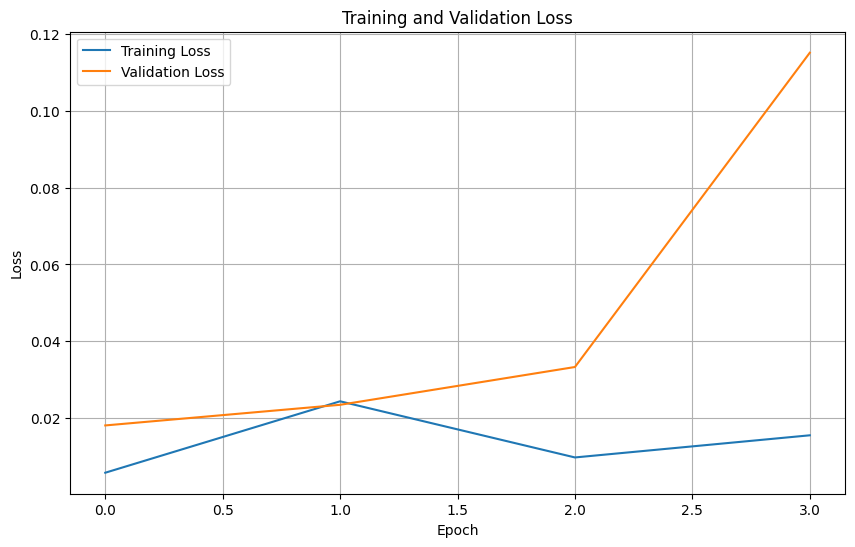

/home/ren/CyberSecurity/ML4N/project/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


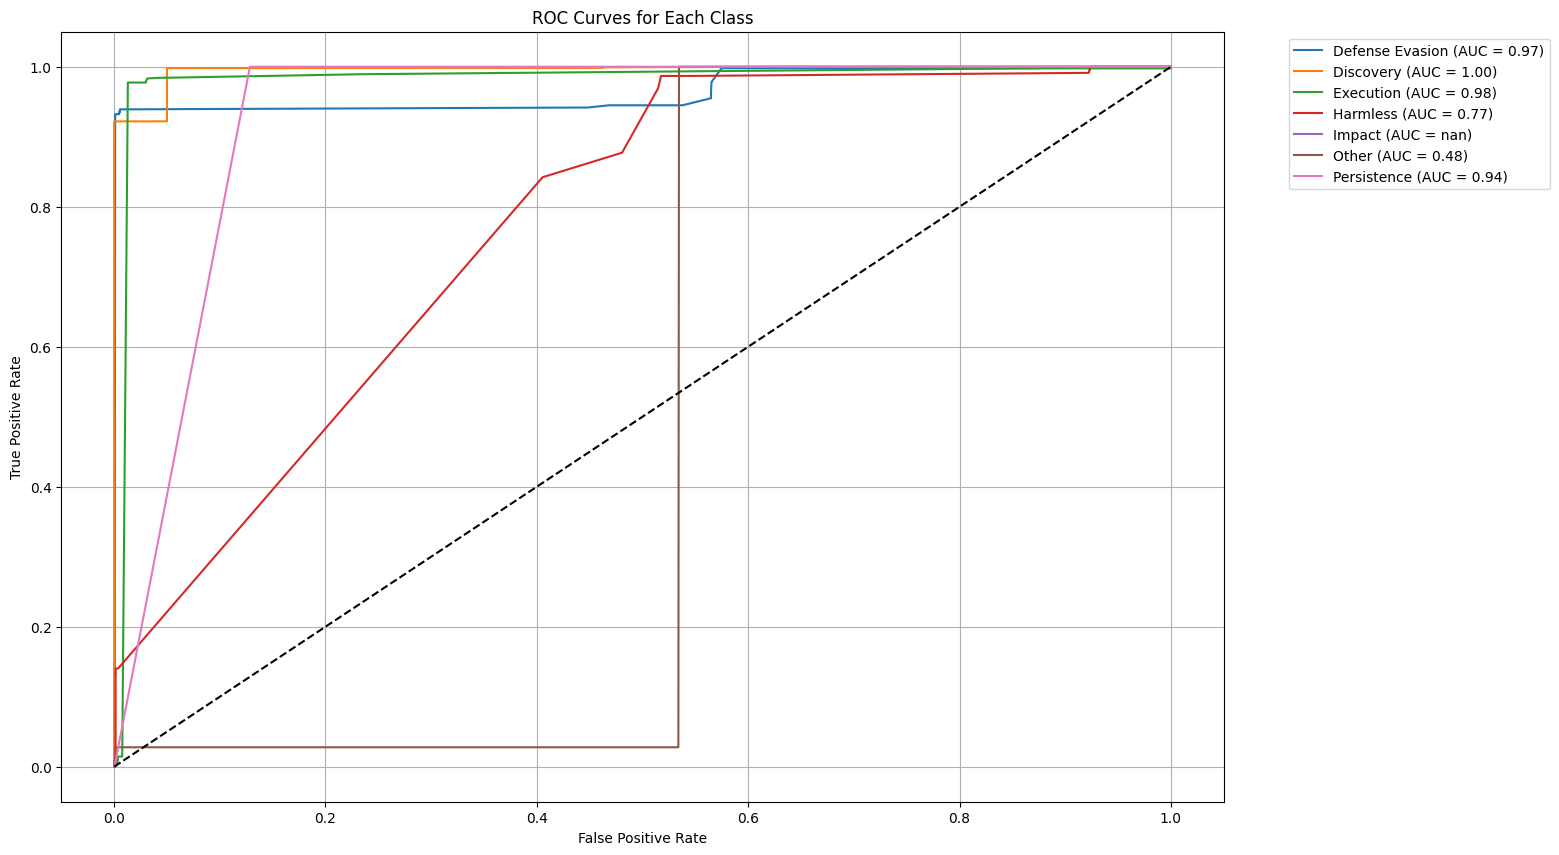

/home/ren/CyberSecurity/ML4N/project/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


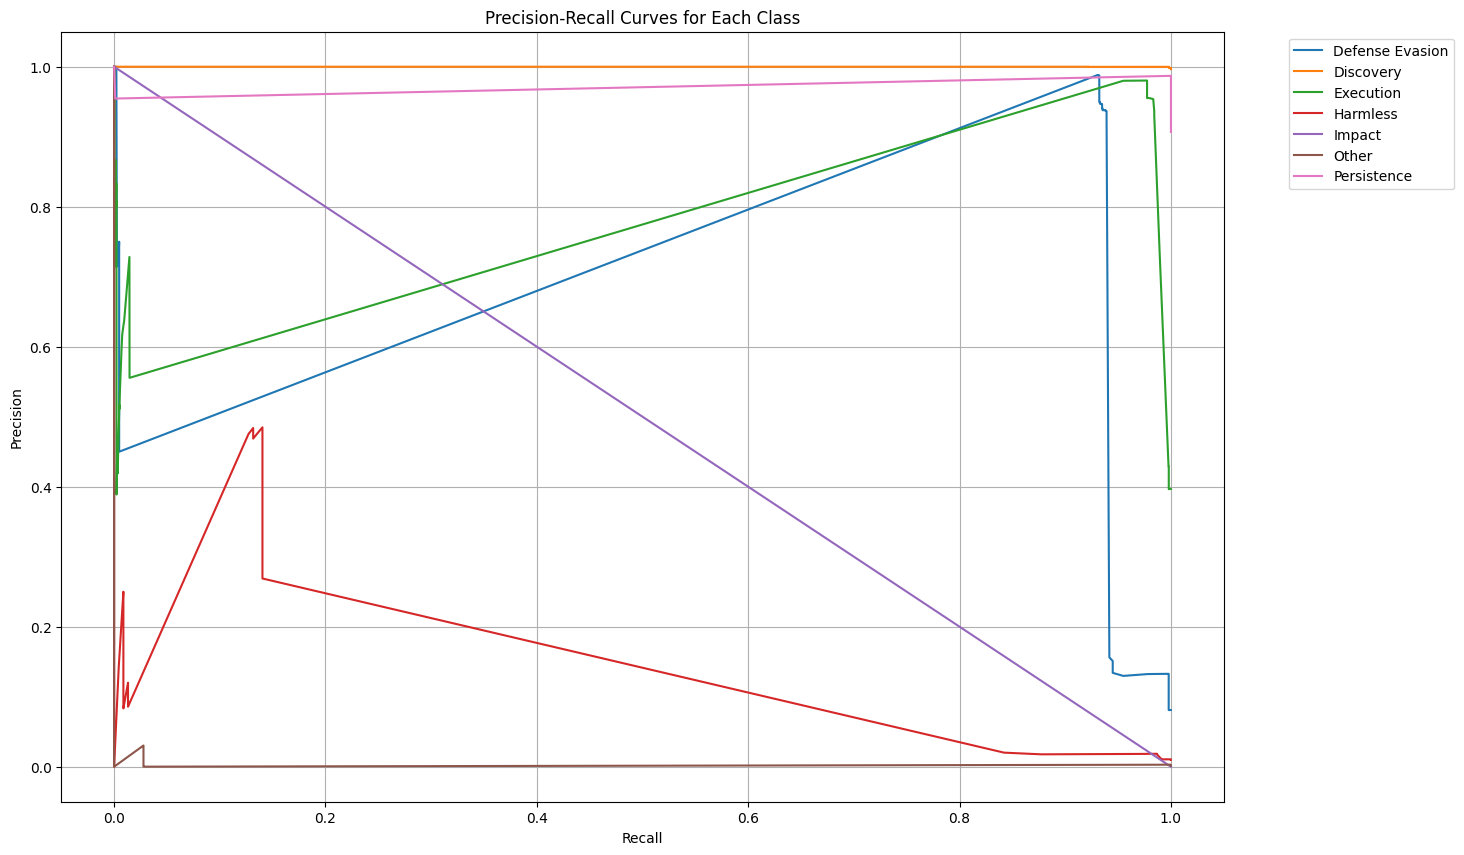

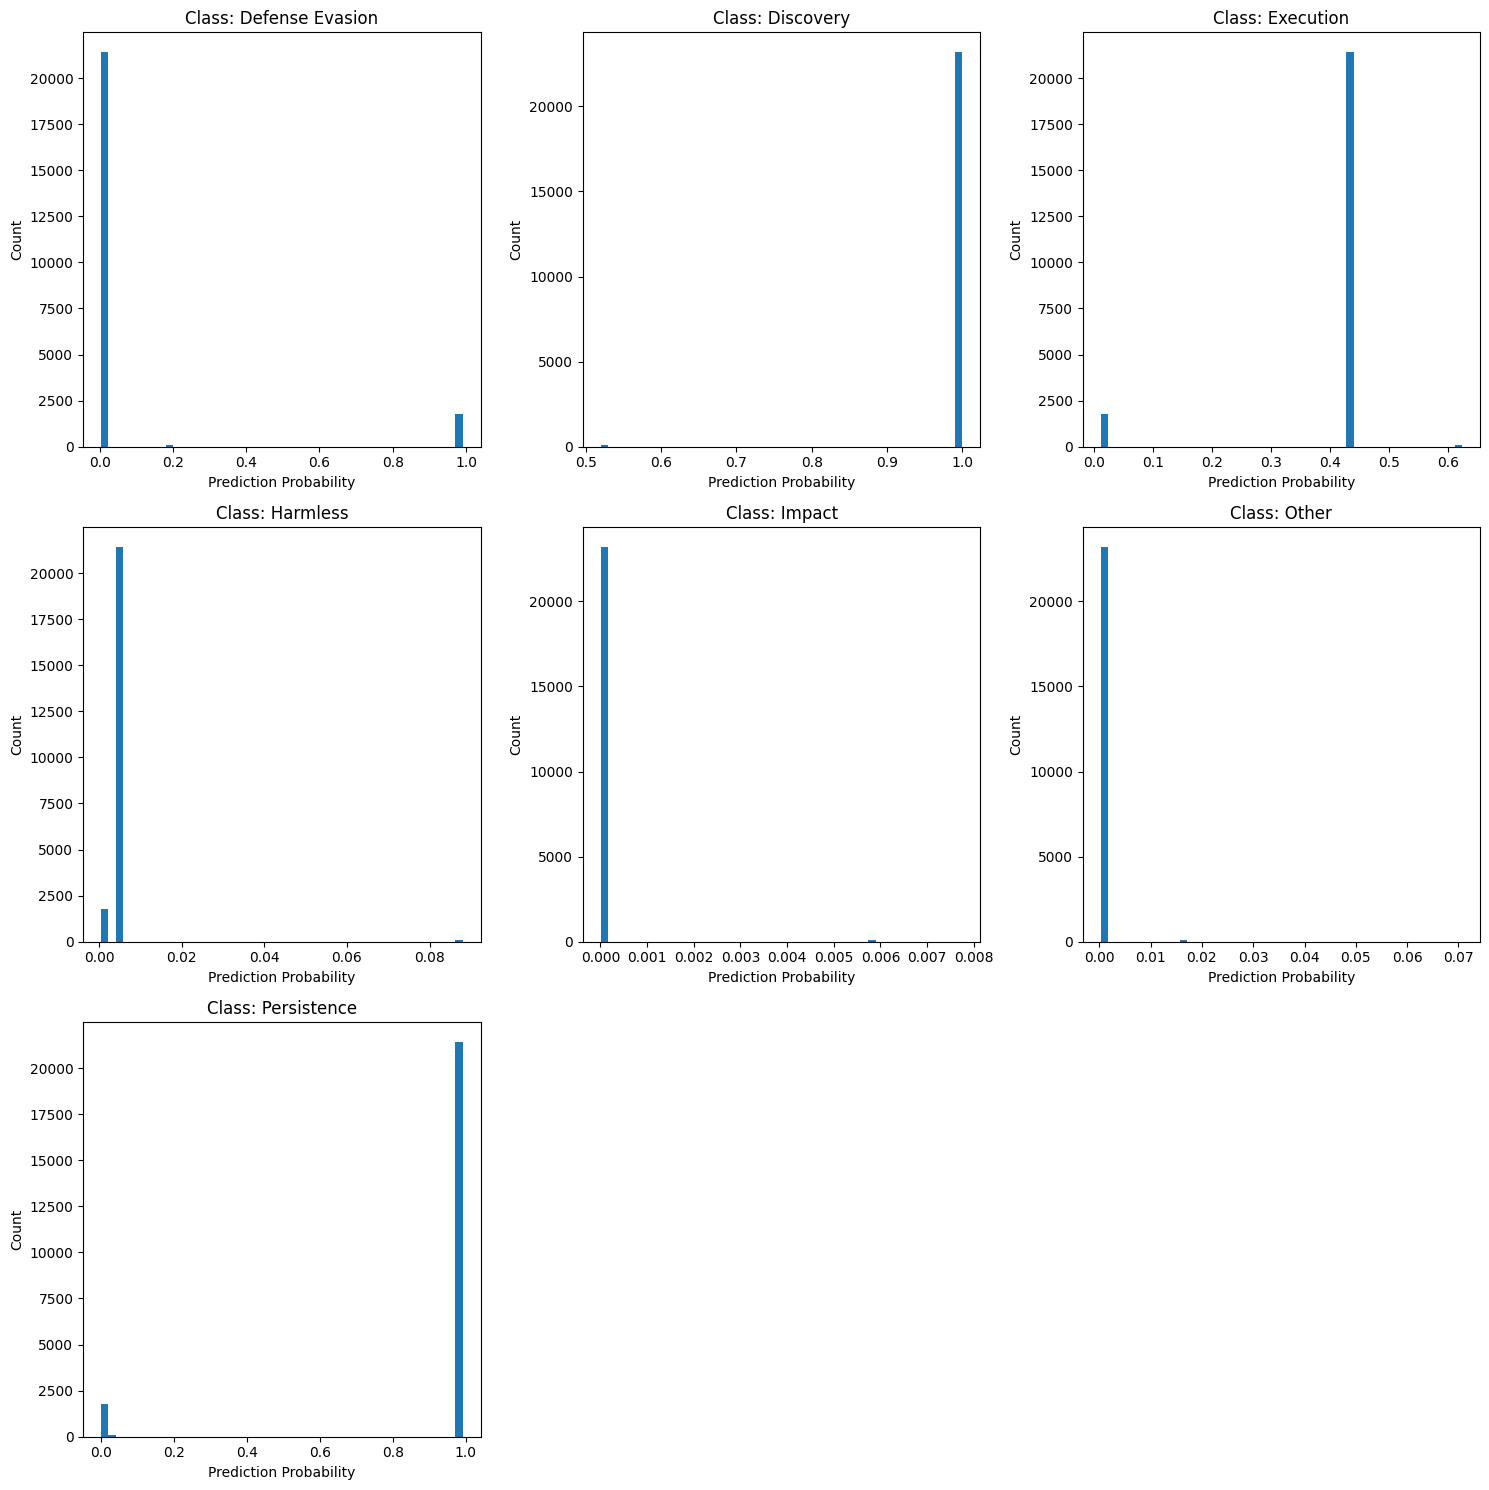

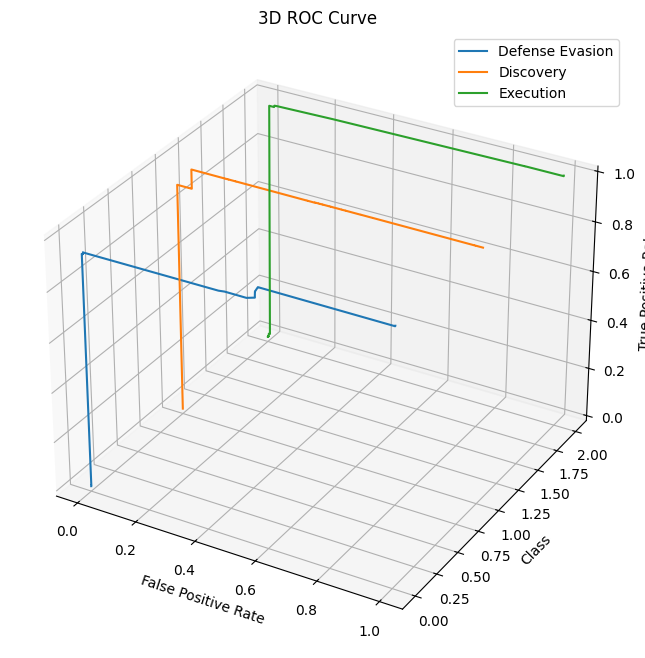

/home/ren/CyberSecurity/ML4N/project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


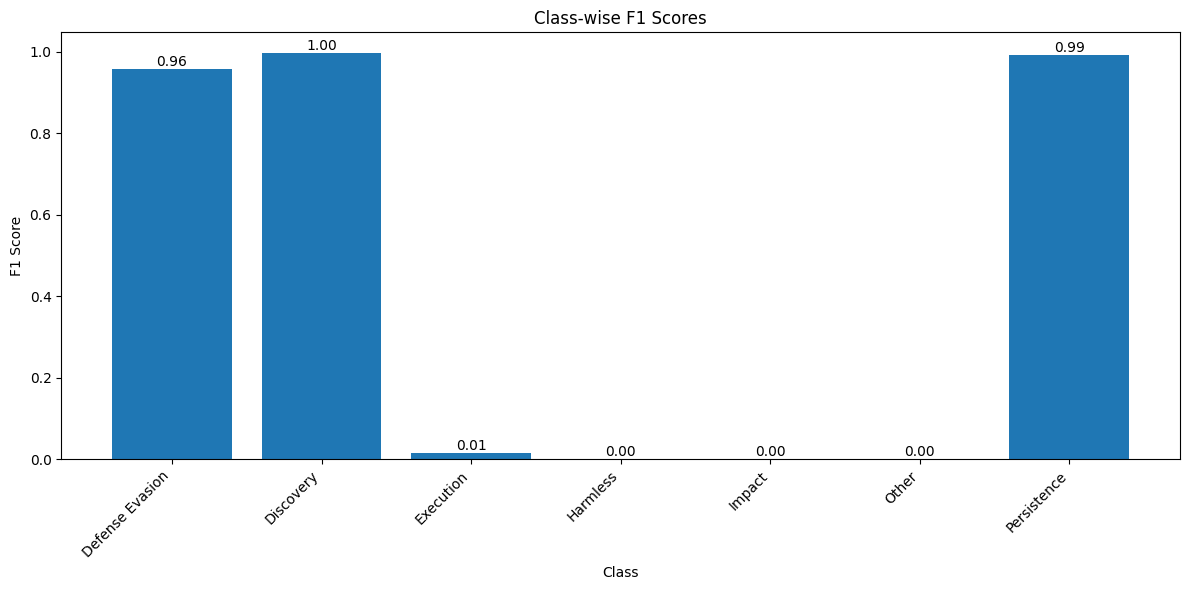

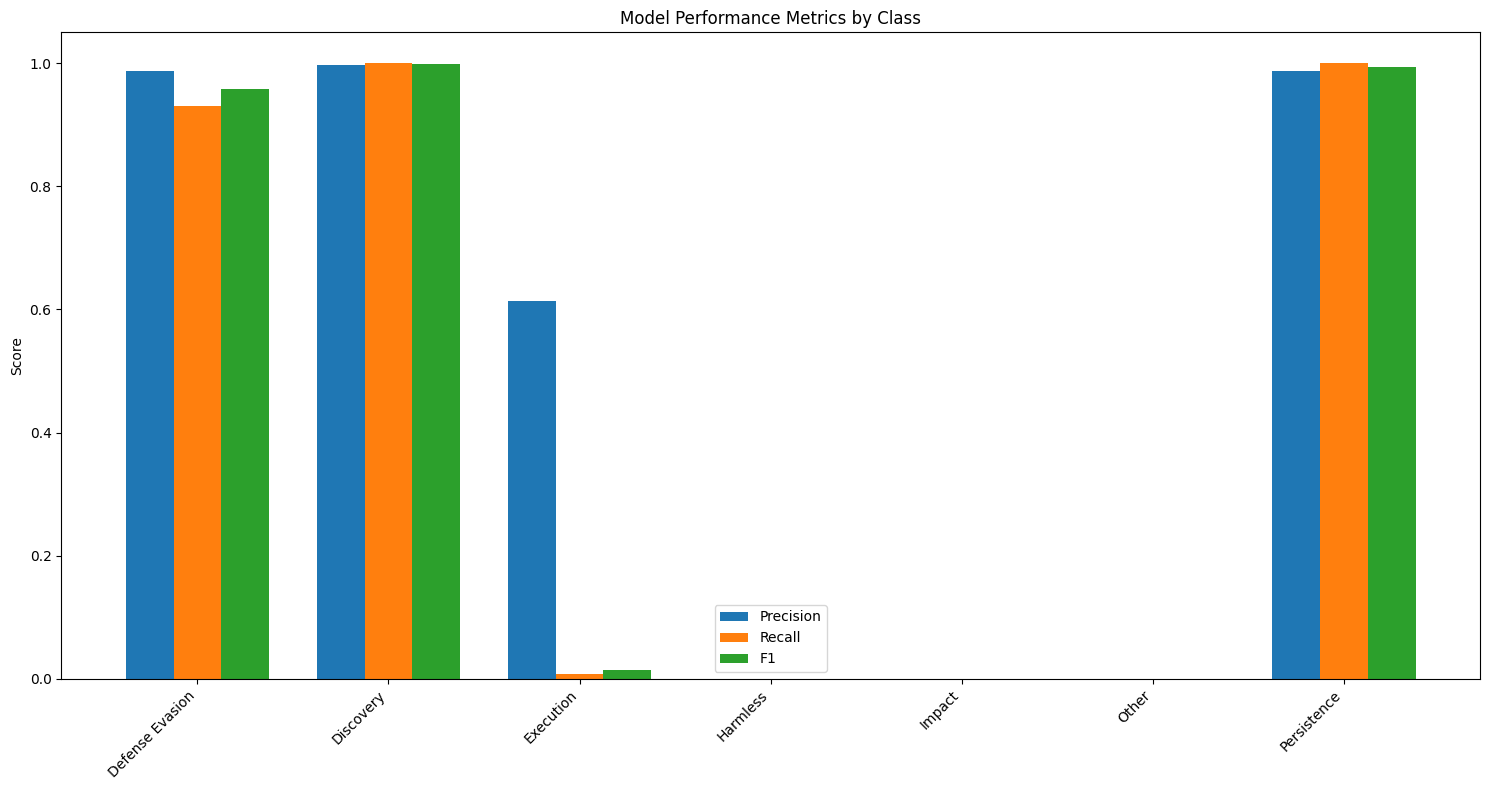

In [32]:
# Assuming you have these variables from your model training:
# y_true: Ground truth labels
# y_pred_probs: Model's predicted probabilities
# train_losses: List of training losses per epoch
# val_losses: List of validation losses per epoch
# class_names: List of your label names
# y_pred_probs_per_epoch: List of prediction probabilities for each epoch

y_true = model_evaluation['true_labels']
y_pred_probs = model_evaluation['predicted_probabilities']
y_pred_probs_per_epoch = model_evaluation['probabilities_per_epoch']
train_losses = model_evaluation['train_losses']
val_losses = model_evaluation['val_losses']
class_names = mlb.classes_  # from your MultiLabelBinarizer

# Generate all plots

# 1. Metrics over epochs
# plot_metrics_over_epochs(y_true, y_pred_probs, len(train_losses))
    
# 2. Loss curves
plot_loss_curves(train_losses, val_losses)
    
# 3. ROC curves
plot_roc_curves(y_true, y_pred_probs, class_names)
    
# 4. Precision-Recall curves
plot_pr_curves(y_true, y_pred_probs, class_names)
    
# 5. Probability histograms
plot_prob_histograms(y_pred_probs, class_names)
    
# 6. 3D ROC curve
plot_3d_roc(y_true, y_pred_probs, class_names)
    
# 7. F1 scores
plot_f1_scores(y_true, y_pred_probs, class_names)
    
# 8. Performance metrics
plot_performance_metrics(y_true, y_pred_probs, class_names)

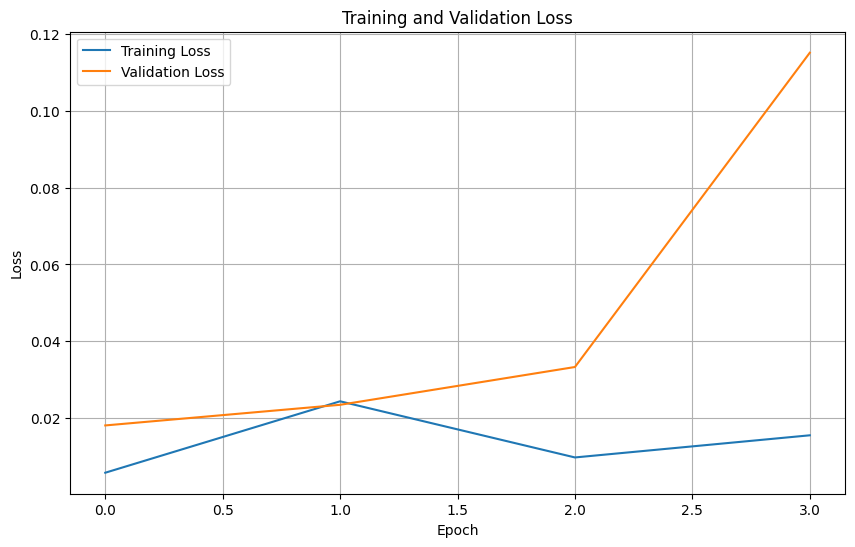

Directory '../results/figures/plots/section4' created.
Plot saved successfully at: '../results/figures/plots/section4/loss_curves.png'


/home/ren/CyberSecurity/ML4N/project/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


<Figure size 640x480 with 0 Axes>

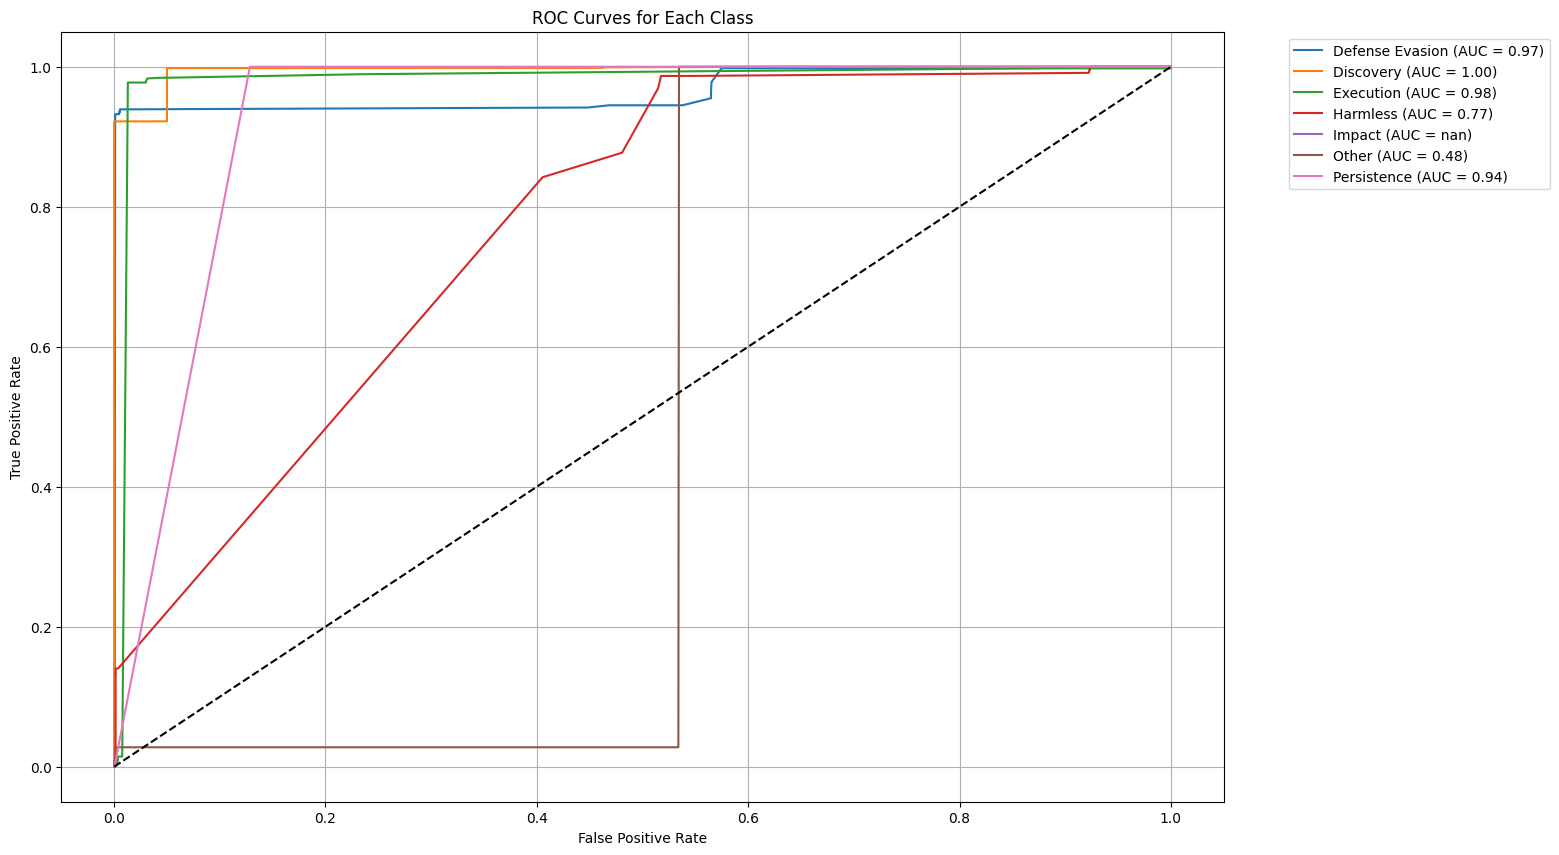

Plot saved successfully at: '../results/figures/plots/section4/roc_curves.png'


/home/ren/CyberSecurity/ML4N/project/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

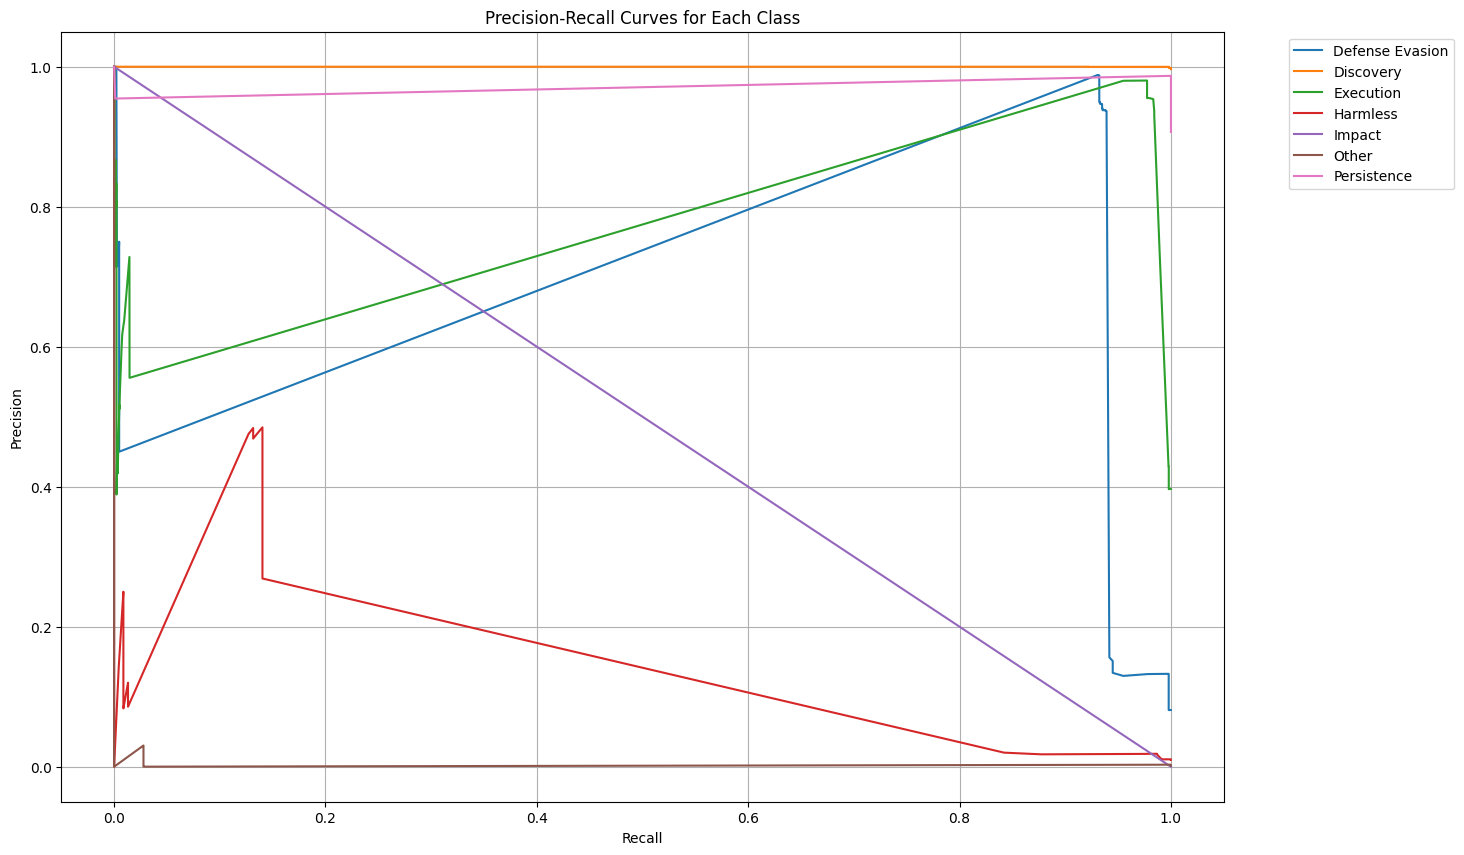

Plot saved successfully at: '../results/figures/plots/section4/precision_recall_curves.png'


<Figure size 640x480 with 0 Axes>

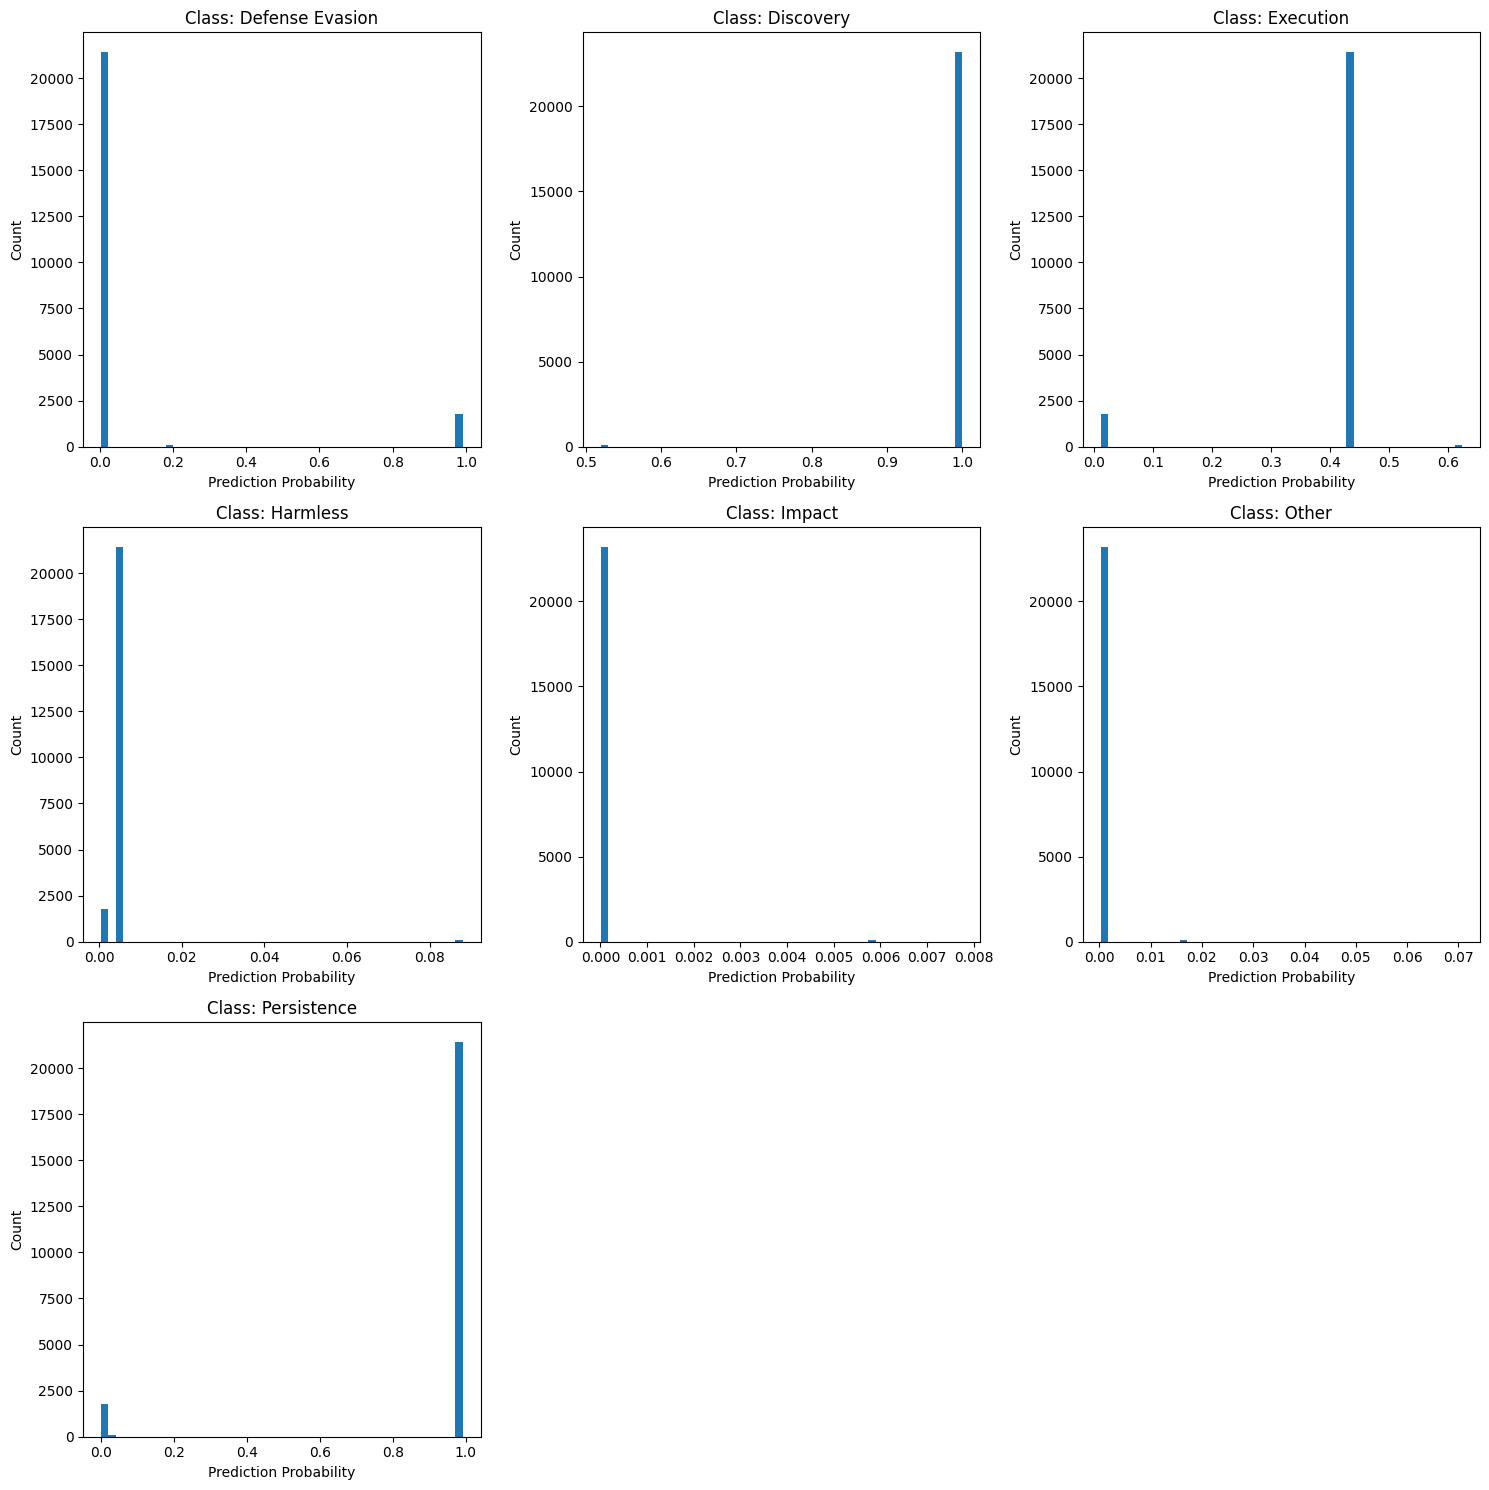

Plot saved successfully at: '../results/figures/plots/section4/probability_histograms.png'


<Figure size 640x480 with 0 Axes>

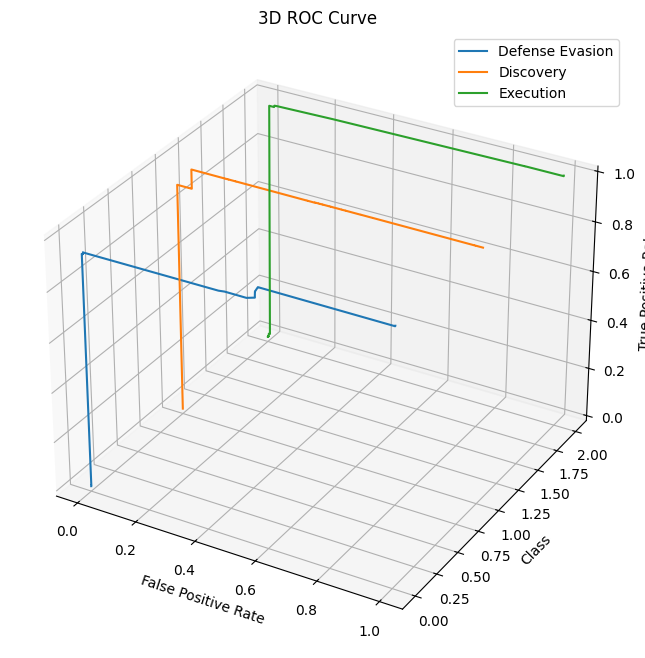

Plot saved successfully at: '../results/figures/plots/section4/3d_roc_curve.png'


/home/ren/CyberSecurity/ML4N/project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 640x480 with 0 Axes>

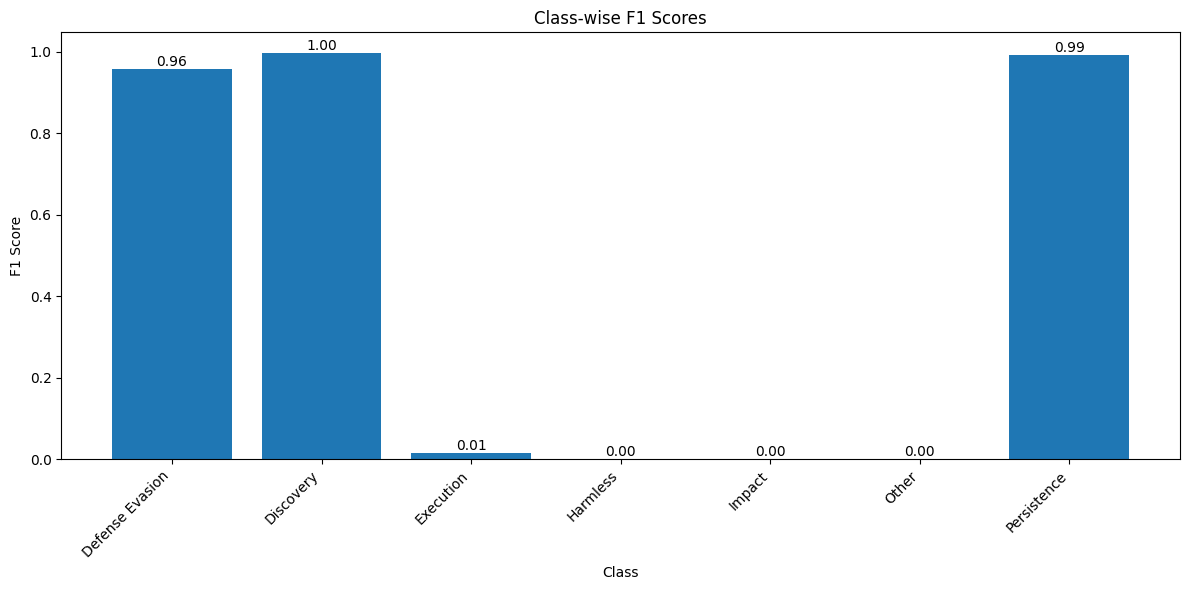

Plot saved successfully at: '../results/figures/plots/section4/f1_scores.png'


<Figure size 640x480 with 0 Axes>

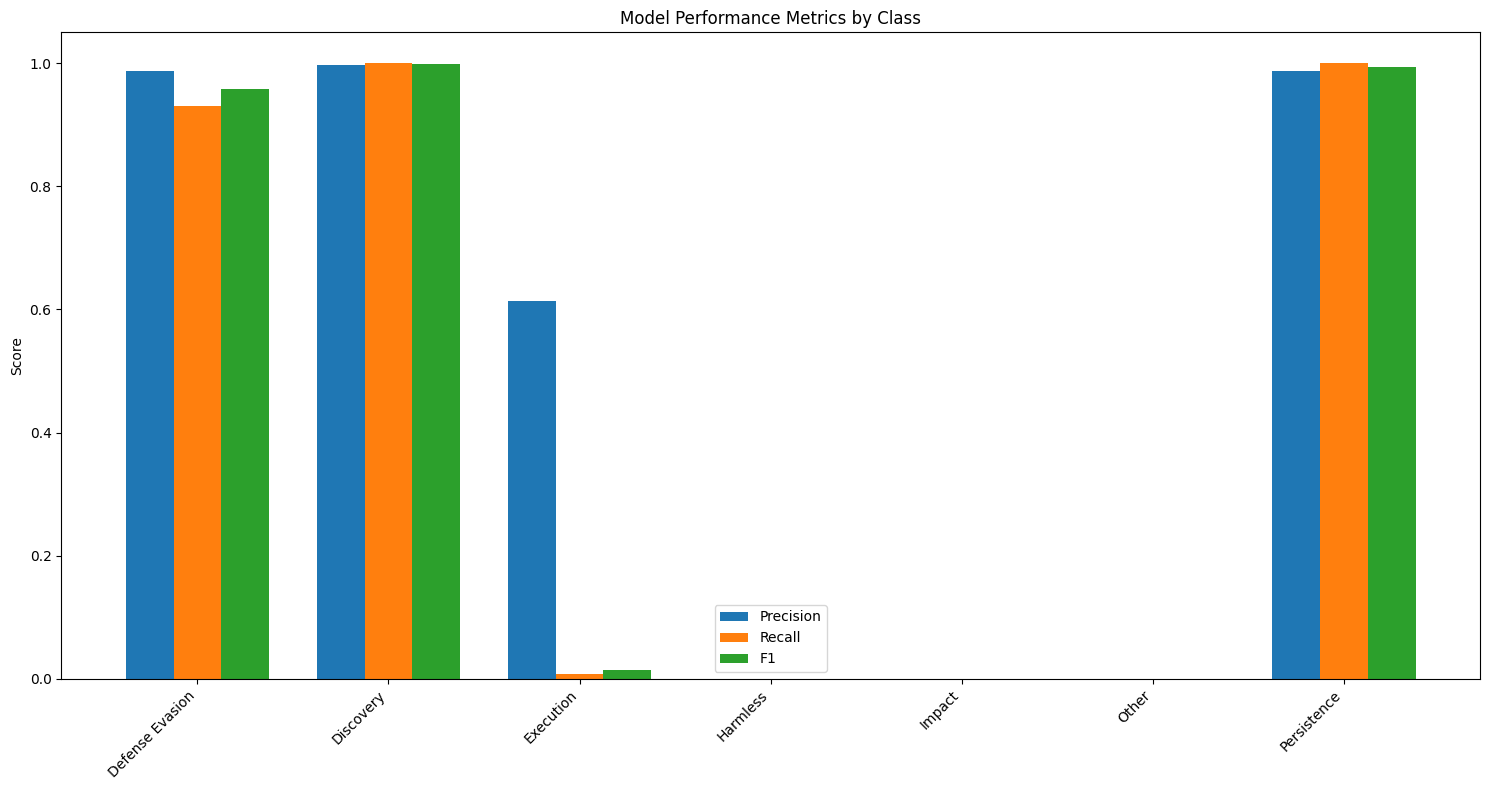

Plot saved successfully at: '../results/figures/plots/section4/performance_metrics.png'


<Figure size 640x480 with 0 Axes>

In [34]:
# Generate and save all plots using plot_and_save
plots_to_generate = [
    # {
    #     "func": plot_metrics_over_epochs,
    #     "args": {"y_true": y_true, "y_pred_probs_per_epoch": y_pred_probs_per_epoch, "num_epochs": len(train_losses)},
    #     "filename": "metrics_over_epochs"
    # },
    {
        "func": plot_loss_curves,
        "args": {"train_losses": train_losses, "val_losses": val_losses},
        "filename": "loss_curves"
    },
    {
        "func": plot_roc_curves,
        "args": {"y_true": y_true, "y_pred_probs": y_pred_probs, "class_names": class_names},
        "filename": "roc_curves"
    },
    {
        "func": plot_pr_curves,
        "args": {"y_true": y_true, "y_pred_probs": y_pred_probs, "class_names": class_names},
        "filename": "precision_recall_curves"
    },
    {
        "func": plot_prob_histograms,
        "args": {"y_pred_probs": y_pred_probs, "class_names": class_names},
        "filename": "probability_histograms"
    },
    {
        "func": plot_3d_roc,
        "args": {"y_true": y_true, "y_pred_probs": y_pred_probs, "class_names": class_names},
        "filename": "3d_roc_curve"
    },
    {
        "func": plot_f1_scores,
        "args": {"y_true": y_true, "y_pred_probs": y_pred_probs, "class_names": class_names},
        "filename": "f1_scores"
    },
    {
        "func": plot_performance_metrics,
        "args": {"y_true": y_true, "y_pred_probs": y_pred_probs, "class_names": class_names},
        "filename": "performance_metrics"
    },
]

# Generate and save each plot
for plot in plots_to_generate:
    plot_and_save(
        plot_func=plot["func"],
        plot_args=plot["args"],
        directory=plot_directory,
        filename=plot["filename"],
        filetype="png",
        overwrite=global_overwrite,
        show_plot=True  # Set to False if you don't want to display plots in the notebook
    )

In [ ]:
########################################################################################################

# Functions To Reuse The Model In Future

In [ ]:
# Save model weights
torch.save(model.state_dict(), "../data/Model/final_model.pth")

# Save optimizer state (optional)
torch.save(optimizer.state_dict(), "../data/Model/optimizer.pth")

# Save the training state (e.g., epoch, loss, etc.) if you need to resume training
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss_list,
    'val_loss': val_loss_list,
}, "checkpoint.pth")


In [ ]:
# Recreate the model
model = BertModel.from_pretrained('bert-base-uncased')

# Load the model weights
model.load_state_dict(torch.load("final_model.pth"))

# Optionally, if you saved the optimizer state, you can load that too
optimizer.load_state_dict(torch.load("optimizer.pth"))

# If you saved a checkpoint, you can load it as follows:
checkpoint = torch.load("checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss_list = checkpoint['train_loss']
val_loss_list = checkpoint['val_loss']